[(1, 0.00143683872), (2, 0.00146334112), (3, 0.0014994464), (4, 0.00153659712), (5, 0.00157252224), (6, 0.00160165104), (7, 0.00163272872), (8, 0.00166217024), (9, 0.00170430648), (10, 0.00173389248), (11, 0.00176793496), (12, 0.0017932352), (13, 0.00181974512), (14, 0.00184514368), (15, 0.001883376), (16, 0.00191116216), (17, 0.00194777536), (18, 0.00198177536), (19, 0.00200502784), (20, 0.00206554568), (21, 0.00210011208), (22, 0.00215297664), (23, 0.00217843008), (24, 0.0022104672), (25, 0.00224088512), (26, 0.00227671296), (27, 0.0023048512), (28, 0.00234405712), (29, 0.00237030432), (30, 0.00241053568), (31, 0.00246612032), (32, 0.00250463808), (33, 0.00253469248), (34, 0.0025686752), (35, 0.00259704752), (36, 0.00265123296), (37, 0.00268627136), (38, 0.00271450688), (39, 0.00274306432), (40, 0.002795568), (41, 0.00283000704), (42, 0.00286320256), (43, 0.00289422912), (44, 0.00292778112), (45, 0.00296404896), (46, 0.00299319616), (47, 0.00303103328), (48, 0.00308946752), (49, 0.00

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


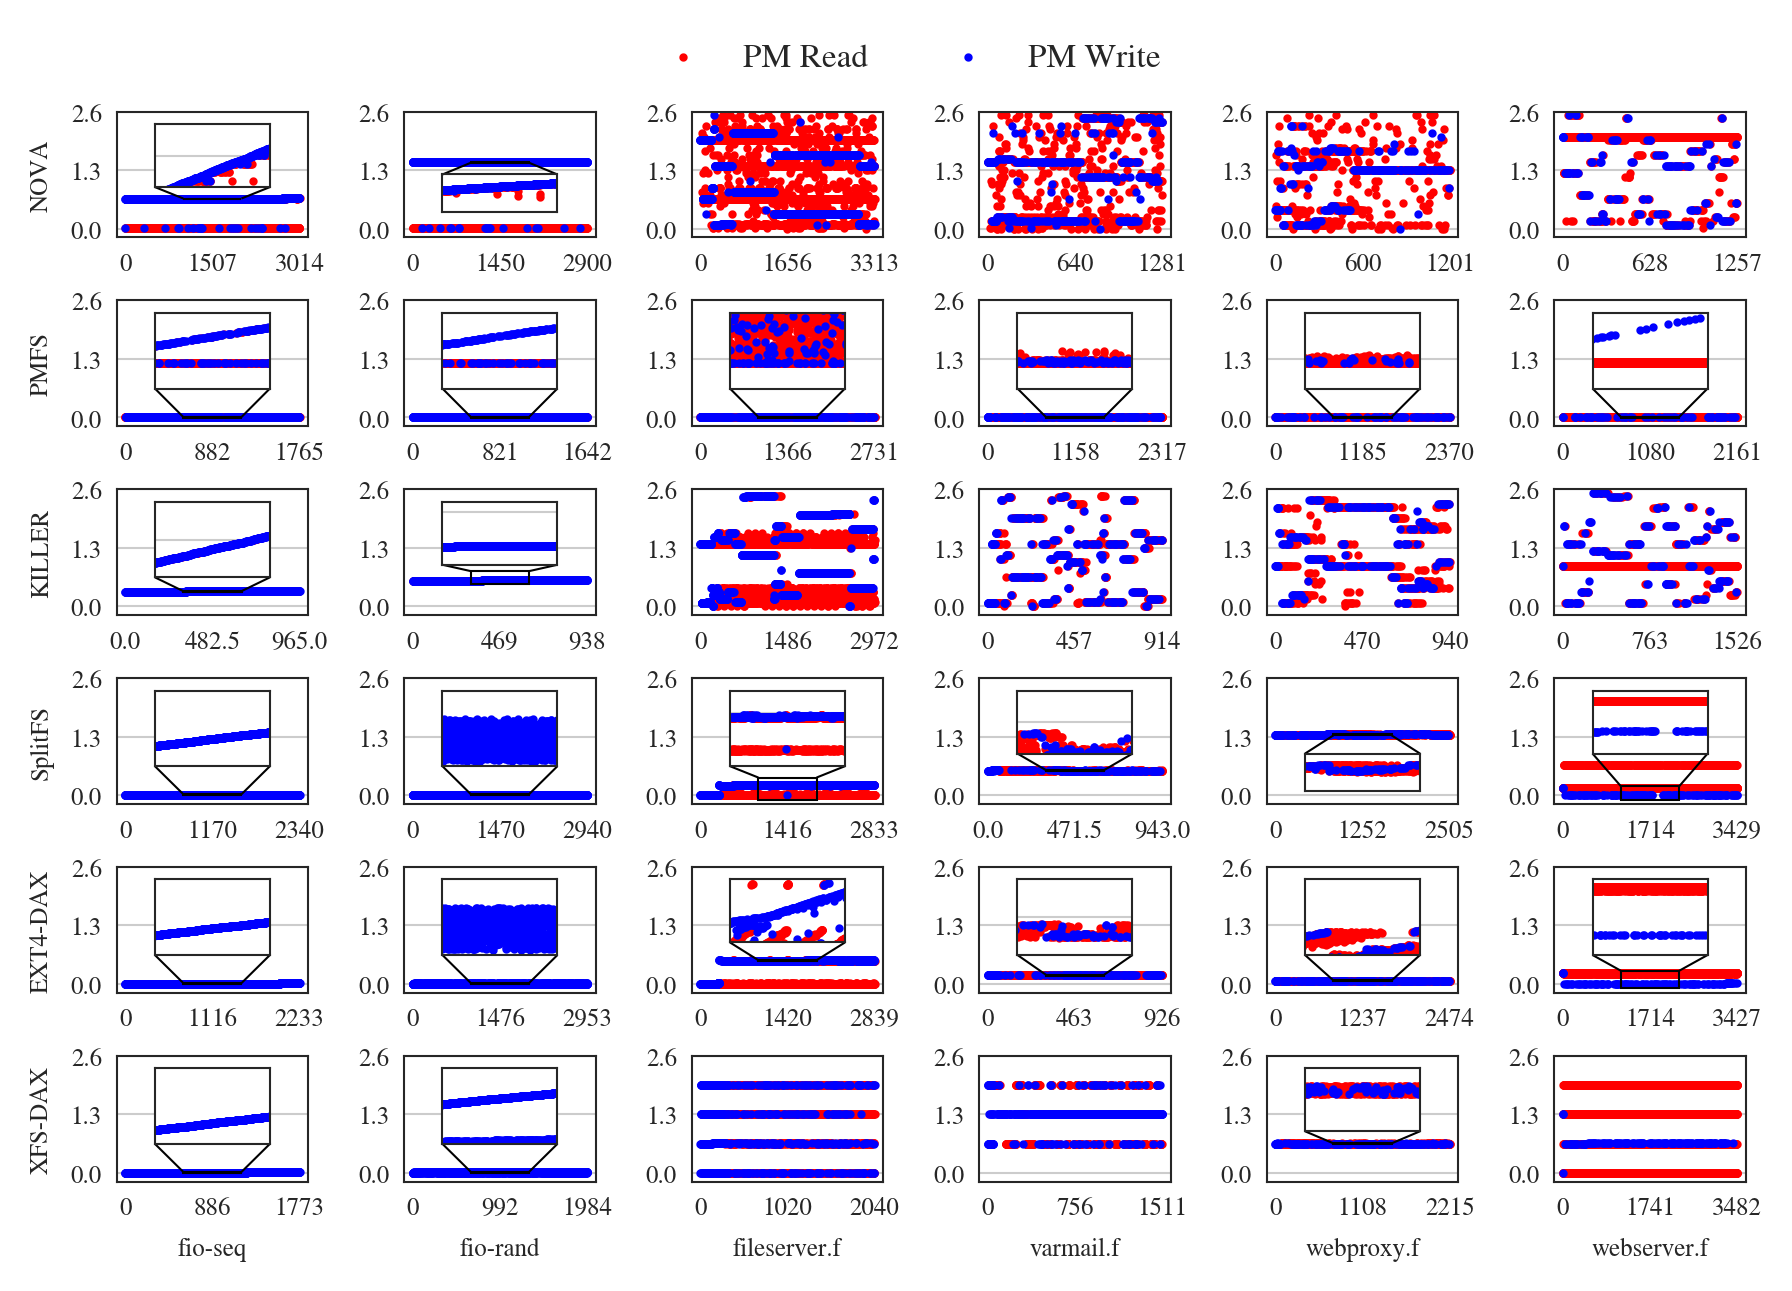

In [4]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
# with open("./performance-comparison-table", "r") as f:
#     df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(12)))

fss = ["NOVA", "PMFS", "KILLER", "SplitFS-FILEBENCH", "EXT4-DAX", "XFS-DAX"]
fss_remaps = ["NOVA", "PMFS", "KILLER", "SplitFS", "EXT4-DAX", "XFS-DAX"]
workloads = [ "fio-seq", "fio-rand", "fileserver.f", "varmail.f", "webproxy.f", "webserver.f" ]
workloads_remap = [ "(a) FIO-Seq", "(b) FIO-Rand", "(c) Fileserver", "(d) Varmail", "(e) Webproxy", "(f) Webserver" ]
pics_filter = [ 2, 3, 4, 5,
                14, 15, 16, 17,
                # 20, 21, 22, 23,
                # 26, 27, 28, 29,
                32, 33, 35]
def format_ax_yticks(ax, yticks_low, y_ticks_high, points, valid_numbers):
    yticks = np.linspace(yticks_low, y_ticks_high, points)
    ax.set_yticks(yticks)
    min_valid_numbers = 0
    for ytick in yticks:
        ytick = str(float(ytick))
        integer_numbers = ytick.split('.')[0]
        if len(integer_numbers) > min_valid_numbers:
            min_valid_numbers = len(integer_numbers)
    
    valid_numbers = valid_numbers if valid_numbers > min_valid_numbers else min_valid_numbers
    new_yticks = []
    for ytick in yticks:
        ytick = str(float(ytick))
        integer_numbers = ytick.split('.')[0]
        decimal_numbers = ytick.split('.')[1]
        if len(decimal_numbers) < (valid_numbers - len(integer_numbers)):
            new_ytick = integer_numbers + '.' + decimal_numbers + '0' * (valid_numbers - len(integer_numbers) - len(decimal_numbers))
        else:
            new_ytick = integer_numbers + '.' + ytick.split('.')[1][:(valid_numbers - len(integer_numbers))]
        new_yticks.append(new_ytick)
    # print(yticks)
    # print(new_yticks)
    ax.set_yticklabels(new_yticks, fontsize=6)

def zoom_in(axins, x, ys, zone_left, zone_right):
    # 坐标轴的扩展比例（根据实际数据调整）
    x_ratio = 0.1 # x轴显示范围的扩展比例
    y_ratio = 0.1 # y轴显示范围的扩展比例

    # X轴的显示范围
    xlim0 = x[zone_left]-(x[zone_right]-x[zone_left])*x_ratio
    xlim1 = x[zone_right]+(x[zone_right]-x[zone_left])*x_ratio

    stack = []
    for y in ys:
        stack.append(y[zone_left:zone_right])
    y = np.hstack(stack)
    ylim0 = np.min(y)-(np.max(y)-np.min(y))*y_ratio
    ylim1 = np.max(y)+(np.max(y)-np.min(y))*y_ratio

    # 调整子坐标系的显示范围
    axins.set_xlim(xlim0, xlim1)
    axins.set_ylim(0, ylim1)
    return (xlim0, xlim1, 0, ylim1)

read_point_line = None
write_point_line = None

gs = gridspec.GridSpec(len(fss), len(workloads), hspace=0.5, wspace=0.5)
for fs_idx, fs in enumerate(fss):
    for workload_idx, workload in enumerate(workloads):
        subfig = plt.subplot(gs[fs_idx, workload_idx])
        read_points = []
        write_points = []
        
        pic_id = fs_idx * len(workloads) + workload_idx

        with open("./PERF_DATA/%s/perf_report_filtered-%s" % (fs, workload), "r") as f:
            lines = f.readlines()
            access_times = 1
            for line_id, line in enumerate(lines):
                # if workload.startswith("fio") and line_id % 10 != 0:
                #     continue
                if not workload.startswith("fio") and line_id % 10 != 0:
                    continue
                if line.startswith("Filter Range"):
                    virt_start = int(" ".join(line.split(" ")).split(" ")[2].strip().split("-")[0], 16)
                    virt_end = int(" ".join(line.split(" ")).split(" ")[2].strip().split("-")[1], 16)
                elif line.startswith("read"):
                    read_points.append((access_times, int(line.split(":")[-1].strip(), 16) - virt_start))
                    access_times += 1
                elif line.startswith("write"):
                    write_points.append((access_times, int(line.split(":")[-1].strip(), 16) - virt_start))
                    access_times += 1
        
        # print(read_points)
        read_points = [(x[0], x[1] / 100_000_000_000) for x in read_points]
        write_points = [(x[0], x[1] / 100_000_000_000) for x in write_points]
        r = plt.scatter([x[0] for x in read_points], [x[1] for x in read_points], marker='o', s=1, color='red')
        w = plt.scatter([x[0] for x in write_points], [x[1] for x in write_points], marker='o', s=1, color='blue')
        if read_point_line is None:
            read_point_line = r
        if write_point_line is None:
            write_point_line = w
        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
        
        # plt.yticks(, fontsize=8)
        plt.ylim(-0.2, (virt_end - virt_start) / 100_000_000_000)
        plt.xticks(np.linspace(0, access_times, 3), fontsize=6)
        # plt.yticks(np.linspace(0, (virt_end - virt_start) / 100_000_000_000, 3), fontsize=6)
        format_ax_yticks(ax, 0, (virt_end - virt_start) / 100_000_000_000, 3, 2)
        if fs_idx == len(fss) - 1:
            plt.xlabel(workloads[workload_idx], fontsize=6)
        if workload_idx == 0:
            plt.ylabel(fss_remaps[fs_idx], fontsize=6)
            # plt.title(subfig_titles[workload_idx], fontsize=8)
        
        # Zoom
        if pic_id not in pics_filter:
            # custom configures
            axins_x0 = 0.2
            axins_y0 = 0.3
            axins_width = 0.6
            axins_height = 0.6
            pp1_loc1, pp1_loc2, pp2_loc1, pp2_loc2 = 3, 2, 4, 1 
            if fs == "KILLER":
                if workload == "fio-seq":
                    ylim_left = 0.335
                    ylim_right = 0.345
                else:
                    ylim_left = 0.5
                    ylim_right = 0.8
                    axins_y0 += 0.1
                    axins_height -= 0.1
            elif fs == "NOVA":
                if workload == "fio-seq":
                    ylim_left = 0.68
                    ylim_right = 0.685
                    axins_y0 += 0.1
                    axins_height -= 0.1
                else:
                    ylim_left = 1.5
                    ylim_right = 1.52
                    axins_y0 -= 0.1
                    axins_height = 0.3
                    pp1_loc1, pp1_loc2, pp2_loc1, pp2_loc2 = 2, 3, 1, 4
            elif fs == "PMFS":
                ylim_left = -0.005    
                ylim_right = 0.01
            elif fs == "SplitFS-FILEBENCH":
                ylim_left = 0    
                ylim_right = 0.02
                if workload == "fileserver.f":
                    ylim_left = -0.1
                    ylim_right = 0.4
                if workload == "varmail.f":
                    ylim_left = 0.56
                    ylim_right = 0.57
                    axins_y0 += 0.1
                    axins_height -= 0.1
                if workload == "webproxy.f":
                    ylim_left = 1.36
                    ylim_right = 1.39
                    axins_y0 -= 0.2
                    axins_height = 0.3
                    pp1_loc1, pp1_loc2, pp2_loc1, pp2_loc2 = 2, 3, 1, 4
                    
                if workload == "webserver.f":
                    ylim_left = -0.1
                    ylim_right = 0.2
                    axins_y0 += 0.1
                    axins_height -= 0.1
                    
            elif fs == "EXT4-DAX":
                ylim_left = 0    
                ylim_right = 0.02
                if workload == "fileserver.f":
                    ylim_left = 0.52
                    ylim_right = 0.54
                    axins_y0 += 0.1
                    axins_height -= 0.1
                    print(write_points)
                if workload == "varmail.f":
                    ylim_left = 0.19
                    ylim_right = 0.21
                    print(write_points)
                    
                if workload == "webproxy.f":
                    ylim_left = 0.067
                    ylim_right = 0.08
                    print(write_points)
                    
                if workload == "webserver.f":
                    ylim_left = -0.1
                    ylim_right = 0.3
                    print(write_points)
                    
            elif fs == "XFS-DAX":
                ylim_left = 0    
                ylim_right = 0.02
                if workload == "webproxy.f":
                    ylim_left = 0.66
                    ylim_right = 0.67
                    axins_y0 += 0.1
                    axins_height -= 0.1
                    print(write_points)
                    
            else:
                ylim_left = 0    
                ylim_right = 0.02
            
            # start to plot
            axins = ax.inset_axes((axins_x0, axins_y0, axins_width, axins_height))
            
            axins.scatter([x[0] for x in read_points], [x[1] for x in read_points], marker='o', s=1, color='red')
            axins.scatter([x[0] for x in write_points], [x[1] for x in write_points], marker='o', s=1, color='blue')
            for tick in axins.get_yaxis().get_major_ticks():
                tick.set_pad(1)
            for tick in axins.get_xaxis().get_major_ticks():
                tick.set_pad(1)
            lw = 0.5
            for axis in ['top','bottom','left','right']:
                axins.spines[axis].set_linewidth(lw)

            # tx0, tx1, ty0, ty1 = zoom_in(axins, [x[0] for x in read_points], [x[1] for x in read_points], len(tail_latency_percentiles) - 5, len(tail_latency_percentiles) - 1)
            
            axins.set_ylim(ylim_left, ylim_right)
            axins.set_yticklabels([])
            # if not workload.startswith("fio"):
            #     axins.set_xlim(access_times / 3, access_times / 3 + 1200)
            #     axins.set_xticklabels([])
            # else: 
            axins.set_xlim(access_times / 3, access_times * 2 / 3)
            axins.set_xticklabels([])
            # axins.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
            # axins.set_xticks(np.linspace(len(tail_latency_percentiles) - 4, len(tail_latency_percentiles), 5))
            patch, pp1, pp2 = mark_inset(ax, axins, loc1 = 3, loc2 = 4, fc="none", ec='k', lw=0.5)
            pp1.loc1 = pp1_loc1
            pp1.loc2 = pp1_loc2
            pp2.loc1 = pp2_loc1
            pp2.loc2 = pp2_loc2
# legend_labels = fss
fig.legend([r, w], ["PM Read", "PM Write"], loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=6, fontsize=8, frameon=False)
# plt.tight_layout()
plt.savefig("./FIG-Pattern.pdf", bbox_inches='tight', pad_inches=0)
plt.savefig("./FIG-Pattern.svg", bbox_inches='tight', pad_inches=0)
